1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!date

Wed Feb 28 03:39:48 EST 2018


In [4]:
project_name='plant-seedlings-classification'

In [5]:
import os, sys

In [6]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [7]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import os
from planet import *

In [8]:
PATH = "/home/paperspace/data/seeds/"
#PATH = "/Users/vinod/programming/DL/data/seedlings/"
assert os.path.exists(PATH)

## Get data

### Directory based structure

In [9]:
!ls {PATH}

lr_plot.png  sample_submission.csv.zip	tmp    train.zip
models	     test			train  valid


In [10]:
notebook_dir = os.getcwd()
notebook_dir

'/home/paperspace/fastai/courses/dl1'

In [11]:
os.chdir(PATH)

In [12]:
! pwd

/home/paperspace/data/seeds


In [13]:
dir_list = os.listdir('train/')
dir_list.remove('.DS_Store')
dir_list

ValueError: list.remove(x): x not in list

In [ ]:
from random import sample

for dir in dir_list:
    print(dir)
    #files = np.random.permutation(os.listdir(f'train/{dir}'))
    files = os.listdir(f'train/{dir}')
    no_of_valid_files = round(len(files) / 10) # 10%
    print(no_of_valid_files)
    random_files = sample(files, no_of_valid_files)
    print(random_files[:3])
    for file in random_files:
        os.renames(f'{PATH}/train/{dir}/{file}', f'valid/{dir}/{file}') 
    os.listdir(f'{PATH}valid/{dir}/')

In [14]:
!ls {PATH}valid

Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [15]:
# MAX size
files = !ls -S {PATH}valid/Maize | head
files

['c9b1820d0.png',
 '5c7abc049.png',
 '9d588ace5.png',
 '3ad5d809c.png',
 'b496ed692.png',
 '084d21b80.png',
 'a5c2eec2d.png',
 '85ae913c3.png',
 '66e90b455.png',
 '266211c3c.png']

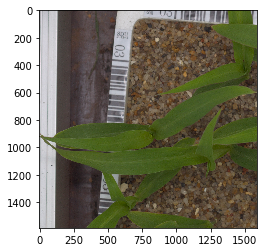

In [16]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [17]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(1588, 1588, 3)

In [18]:
# MIN size
files = !ls -rS {PATH}valid/Maize | head
files

['16e38d4af.png',
 '69f06fcbc.png',
 '7446f241c.png',
 '50c80a5e4.png',
 '8bfe6860d.png',
 '18b6755a1.png',
 '55083690a.png',
 '3ef465952.png',
 '606d5c83f.png',
 'ff4b55219.png']

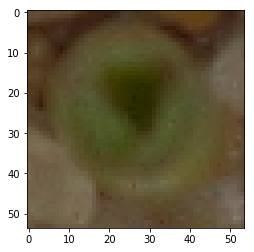

In [19]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [20]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(54, 54, 3)

In [21]:
os.chdir(notebook_dir)

In [22]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [23]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [24]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [25]:
def get_data_from_dir(f_mode, sz, tfms, **kwargs):
    return ImageClassifierData.from_paths(PATH, bs, tfms=tfms_from_model(arch, sz), test_name='test')

# Enable data augmentation, and precompute=True

## Initial model setup

In [26]:
arch=resnet34
size=60 
bs=64 # default
#metrics=[f2]

In [27]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size))

In [28]:
learn = ConvLearner.pretrained(arch, data, ps=[0.3, .6])
#learn = ConvLearner.pretrained(arch, data, ps=.6)

In [29]:
learn

Sequential(
  (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [30]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 62/67 [00:06<00:00,  9.01it/s, loss=11.2]


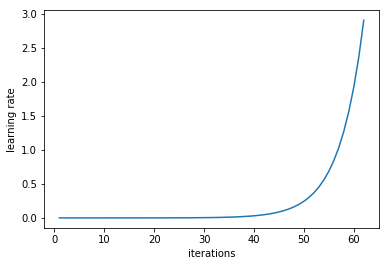

In [31]:
learn.sched.plot_lr()

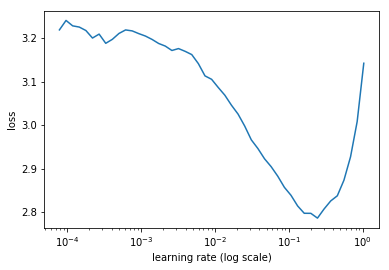

In [32]:
learn.sched.plot()

# Train last layer from precomputed activations for 1-2 epochs

In [33]:
#learning_rate = 0.15 # 0.96977
learning_rate = 0.1 # Best so far
learning_rates = [learning_rate/9, learning_rate/3, learning_rate]

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.306394   1.441558   0.509621  
    1      1.939597   1.280616   0.549407                 
    2      1.530464   1.152822   0.610894                 
    3      1.465467   1.12233    0.624566                 
    4      1.343653   1.086289   0.631149                 
    5      1.221317   1.073198   0.612847                 
    6      1.128598   1.065408   0.6148                   

CPU times: user 5min 21s, sys: 16.3 s, total: 5min 37s
Wall time: 1min


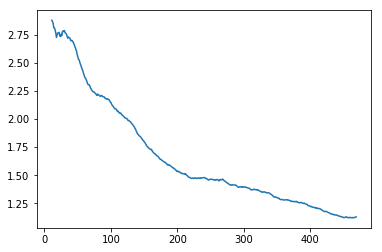

In [34]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.143794   0.713292   0.757378  
    1      0.802212   0.548827   0.802517                  
    2      0.483177   0.342438   0.881366                  
    3      0.497744   0.844472   0.721065                  
    4      0.380738   0.445425   0.839627                  
    5      0.240976   0.299274   0.897497                  
    6      0.156487   0.282452   0.89945                   

CPU times: user 5min 56s, sys: 27.4 s, total: 6min 24s
Wall time: 1min 39s


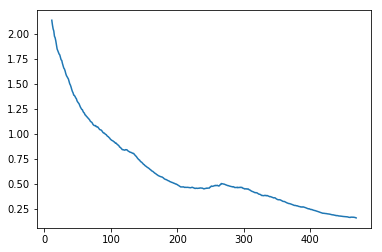

In [35]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [36]:
size = 150 # about 600 of them
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.138164   0.778878   0.760055  
    1      0.951967   0.618155   0.792028                  
    2      0.816506   0.563243   0.801794                  
    3      0.817157   0.564098   0.818866                  
    4      0.772955   0.500815   0.828631                  
    5      0.701573   0.470756   0.830367                  
    6      0.630105   0.458167   0.853299                  

CPU times: user 6min 17s, sys: 31.9 s, total: 6min 49s
Wall time: 1min 47s


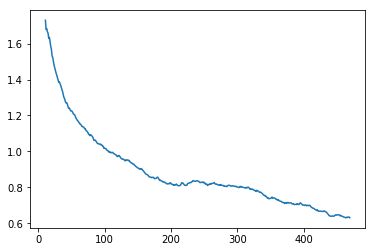

In [37]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.595065   0.312553   0.897714  
    1      0.425812   0.437509   0.87037                   
    2      0.25885    0.172253   0.949725                  
    3      0.285273   0.640464   0.796152                  
    4      0.219316   0.335413   0.894314                  
    5      0.127368   0.150085   0.960214                  
    6      0.086984   0.140144   0.96998                    

CPU times: user 8min 13s, sys: 1min 20s, total: 9min 34s
Wall time: 4min 21s


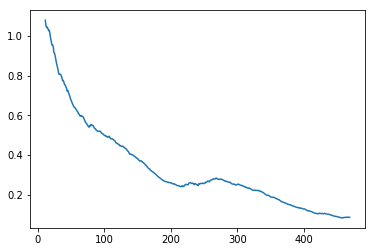

In [38]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [39]:
size = 400
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.539361   0.361842   0.888455  
    1      0.455902   0.293932   0.917752                  
    2      0.383843   0.280553   0.917752                  
    3      0.379568   0.259275   0.923611                  
    4      0.341946   0.264104   0.927517                  
    5      0.297927   0.229247   0.931424                  
    6      0.28029    0.225899   0.933377                  

CPU times: user 12min 35s, sys: 3min 29s, total: 16min 5s
Wall time: 8min 5s


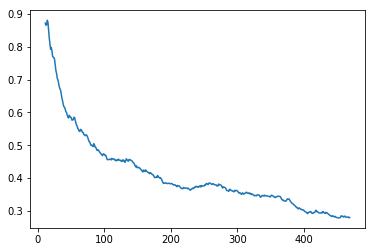

In [40]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.476018   0.231423   0.928964  
    1      0.354123   0.443505   0.865741                  
    2      0.206392   0.132411   0.968027                  
    3      0.215277   0.54368    0.8091                    
    4      0.166406   0.209233   0.950448                  
    5      0.100179   0.110405   0.973886                  
    6      0.066147   0.104124   0.975839                   

CPU times: user 22min 17s, sys: 6min 17s, total: 28min 35s
Wall time: 20min 39s


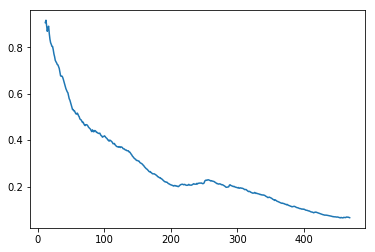

In [41]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

## Current latest standing doesn't include the following fit'

In [42]:
size = 500
bs=32
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.08592    0.112572   0.974614  
    1      0.084949   0.117386   0.972531                     
    2      0.069369   0.113971   0.976698                     
    3      0.108599   0.114797   0.974614                    
    4      0.085892   0.118658   0.974614                     
    5      0.056896   0.125515   0.972531                     
    6      0.063737   0.120731   0.974614                     

CPU times: user 16min 5s, sys: 4min 25s, total: 20min 31s
Wall time: 10min 56s


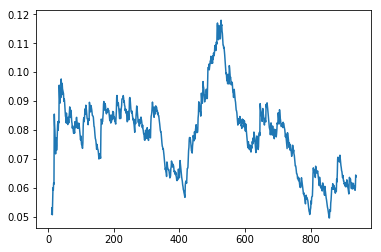

In [43]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.409699   0.15033    0.957948  
    1      0.357178   0.236079   0.901698                    
    2      0.153625   0.106197   0.974614                    
    3      0.365403   0.353677   0.887114                    
    4      0.224851   0.135203   0.966667                    
    5      0.123174   0.111029   0.975                       
    6      0.067825   0.09095    0.975                        

CPU times: user 30min 45s, sys: 9min 56s, total: 40min 42s
Wall time: 31min 11s


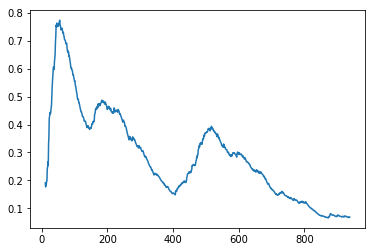

In [44]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

# Check accuracy

## Validation set

In [45]:
log_preds, y = learn.TTA()

In [46]:
log_preds.shape

(5, 475, 12)

In [47]:
log_preds[:,0,:]

array([[ -0.25591, -17.89381, -15.49514, -16.46955,  -7.00206, -11.40772,  -1.49226, -14.68512, -13.72887,
        -17.12062, -13.86621, -16.02908],
       [ -0.25591, -17.89381, -15.49514, -16.46955,  -7.00206, -11.40772,  -1.49226, -14.68512, -13.72887,
        -17.12062, -13.86621, -16.02908],
       [ -0.25591, -17.89381, -15.49514, -16.46955,  -7.00206, -11.40772,  -1.49226, -14.68512, -13.72887,
        -17.12062, -13.86621, -16.02908],
       [ -0.25591, -17.89381, -15.49514, -16.46955,  -7.00206, -11.40772,  -1.49226, -14.68512, -13.72887,
        -17.12062, -13.86621, -16.02908],
       [ -0.25591, -17.89381, -15.49514, -16.46955,  -7.00206, -11.40772,  -1.49226, -14.68512, -13.72887,
        -17.12062, -13.86621, -16.02908]], dtype=float32)

In [48]:
y.shape

(475,)

In [49]:
y[:5]

array([0, 0, 0, 0, 0])

In [50]:
probs = np.mean(np.exp(log_preds), 0)

In [51]:
probs.shape

(475, 12)

In [52]:
probs[0,:]

array([ 0.77421,  0.     ,  0.     ,  0.     ,  0.00091,  0.00001,  0.22486,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ], dtype=float32)

In [53]:
# accuracy(probs, y)

### F1 metrics

In [54]:
from sklearn.metrics import f1_score

In [55]:
probs_idx = np.argmax(probs, axis=1)
probs_idx.shape

(475,)

In [56]:
f1_score(y, probs_idx, average='macro')

0.97222108617363157

In [57]:
f1_score(y, probs_idx, average='micro') # kaggle

0.97473684210526312

In [58]:
f1_score(y, probs_idx, average='weighted')

0.97469378087845726

## Test set

In [59]:
learn.data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [60]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
# print(accuracy(test_probs, test_y))

In [61]:
print(test_probs.shape)
print(test_probs[:4])
print(test_probs[0, 0])

(794, 12)
[[ 0.00243  0.00008  0.00005  0.       0.99708  0.00002  0.00024  0.00001  0.       0.       0.       0.00009]
 [ 0.       0.       0.00001  0.       0.       0.00003  0.       0.       0.       0.       0.99995  0.     ]
 [ 0.       0.       0.       0.       0.       0.00001  0.       0.       0.       0.       0.99998  0.     ]
 [ 0.       0.       0.       0.       0.       0.       0.       1.       0.       0.       0.       0.     ]]
0.00242578


In [62]:
class_indexes = np.argmax(test_probs, axis=1)

In [63]:
learn.data.classes[class_indexes[0]]

'Common wheat'

# Submit to kaggle (optional)

In [64]:
test_classes = [learn.data.classes[i] for i in class_indexes]
print(len(test_classes))
print(test_classes[:5])


794
['Common wheat', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Maize', 'Small-flowered Cranesbill']


In [65]:
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(len(test_filenames))
print(test_filenames[:5])

794
['test/79e5ea8fa.png', 'test/3a909ead8.png', 'test/599691cd9.png', 'test/5ca2687a4.png', 'test/3dd52bd2a.png']


In [66]:
fileIds = np.array([f[5:] for f in test_filenames])
fileIds[:5]

array(['79e5ea8fa.png', '3a909ead8.png', '599691cd9.png', '5ca2687a4.png', '3dd52bd2a.png'], 
      dtype='<U13')

In [67]:
submission = np.stack([fileIds,test_classes], axis=1)
submission[:5]

array([['79e5ea8fa.png', 'Common wheat'],
       ['3a909ead8.png', 'Small-flowered Cranesbill'],
       ['599691cd9.png', 'Small-flowered Cranesbill'],
       ['5ca2687a4.png', 'Maize'],
       ['3dd52bd2a.png', 'Small-flowered Cranesbill']], 
      dtype='<U25')

In [68]:
!pwd

/home/paperspace/fastai/courses/dl1


In [69]:
now = datetime.datetime.now()
submission_file_name = f'plant-seed-submission-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

In [70]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/plant-seed-submission-2018-02-28 05:31:34.538322.csv

In [71]:
!date

Wed Feb 28 05:31:34 EST 2018
